In [24]:
import pandas as pd
pd.set_option("display.max_columns",50)
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose



In [25]:
df_rolled = pd.read_parquet("../data/processed/df_preprocessed.parquet")
df_rolled.shape

(125776, 28)

In [26]:
df_rolled.head()

,week_date,PPG,Retailer_Name,Week,Week_Num,Category,Brand,Sub_Brand,Pack_Type,Pack_Size,Pack_Size_Num,year,week_number,month,Promo_Volume,Non_Promo_Volume,Promo_Value,Non_Promo_Value,Distribution_wtd,Distribution_numeric,Total_Value,Total_Volume,Avg_Price_Per_KG,Promo_Price_Per_KG,Non_Promo_Price_Per_KG,No_Total_Sales_Flag,No_Promo_Sales_Flag,No_Non_Promo_Sales_Flag
0,2018-03-26,BRAND D SUBBRAND D.1.1 ADULT PAK GRONT_KP_RND ...,Retailer A,wk 18 13,1,DRY,BRAND D,SUBBRAND D.1.1,PAK,1000_G,1000,18,13,3,NaN,6606.0,NaN,16711.4,98.0,87.0,NaN,NaN,NaN,NaN,2.529731,1,1,0
1,2018-03-26,BRAND D SUBBRAND D.1.1 ADULT PAK GRONT_KP_RND ...,Retailer B,wk 18 13,1,DRY,BRAND D,SUBBRAND D.1.1,PAK,1000_G,1000,18,13,3,NaN,1104.0,NaN,2627.5,99.0,98.0,NaN,NaN,NaN,NaN,2.379982,1,1,0
2,2018-03-26,BRAND D SUBBRAND D.1.1 ADULT PAK GRONT_KP_RND ...,Retailer C,wk 18 13,1,DRY,BRAND D,SUBBRAND D.1.1,PAK,1000_G,1000,18,13,3,NaN,5477.0,NaN,13390.5,100.0,99.0,NaN,NaN,NaN,NaN,2.444860,1,1,0
3,2018-03-26,BRAND D SUBBRAND D.1.2 ADULT PAK GRANN_GRNT_KP...,Retailer A,wk 18 13,1,DRY,BRAND D,SUBBRAND D.1.2,PAK,1000_G,1000,18,13,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1
4,2018-03-26,BRAND D SUBBRAND D.1.2 ADULT PAK GRANN_GRNT_KP...,Retailer B,wk 18 13,1,DRY,BRAND D,SUBBRAND D.1.2,PAK,1000_G,1000,18,13,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1


### Feature 1 - Category Seasonality and Trend


In [27]:
# Category -  Seasonality, Trend
df_cat_agg = df_rolled.groupby(['Category','Pack_Type','week_date'],as_index=False)\
    .agg({'Total_Volume':'sum'})\
        .sort_values(by=['Category','Pack_Type','week_date'])


df_cat_agg['Category_PackType_Combination'] = df_cat_agg['Category'] +  "*" + df_cat_agg['Pack_Type']

In [28]:
df_cat_agg.head()

,Category,Pack_Type,week_date,Total_Volume,Category_PackType_Combination
0,DRY,PAK,2018-03-26,0.0,DRY*PAK
1,DRY,PAK,2018-04-02,9123.0,DRY*PAK
2,DRY,PAK,2018-04-09,0.0,DRY*PAK
3,DRY,PAK,2018-04-16,1478.0,DRY*PAK
4,DRY,PAK,2018-04-23,7226.0,DRY*PAK


In [29]:
px.bar(df_cat_agg,x='week_date',y='Total_Volume',color='Category_PackType_Combination',)

In [30]:
df_ssn_trend = pd.DataFrame(columns=['Category_PackType_Combination','week_date','seasonal','trend'])

for each_combination in df_cat_agg['Category_PackType_Combination'].unique().tolist():
    # print(each_combination)
    curr_df = df_cat_agg.loc[df_cat_agg['Category_PackType_Combination']==each_combination]
    curr_df.set_index('week_date', inplace=True)
    curr_df = curr_df[['Total_Volume']]

    result = seasonal_decompose(curr_df, model='additive',period=52)


    # vaulue = seasonal + trend + residual
    # multi  = seasonal * trend * residual 


    df_curr_ssn = pd.DataFrame(result.seasonal).reset_index()
    df_curr_trend = pd.DataFrame(result.trend).reset_index()
    df_curr_ssn_trend = pd.merge(df_curr_ssn,df_curr_trend,on='week_date').fillna(0)
    
    df_curr_ssn_trend['seasonal'] =  (df_curr_ssn_trend['seasonal'] - df_curr_ssn_trend['seasonal'].mean()) / df_curr_ssn_trend['seasonal'].std()
    df_curr_ssn_trend['trend'] =  (df_curr_ssn_trend['trend'] - df_curr_ssn_trend['trend'].mean()) / df_curr_ssn_trend['trend'].std()
    
    
    df_curr_ssn_trend['Category_PackType_Combination'] = each_combination
    df_ssn_trend = df_ssn_trend.append(df_curr_ssn_trend)
    

/var/folders/zm/64325rdn3f10y5cfd9wwdz7h0000gn/T/ipykernel_9460/4021420414.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/zm/64325rdn3f10y5cfd9wwdz7h0000gn/T/ipykernel_9460/4021420414.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/zm/64325rdn3f10y5cfd9wwdz7h0000gn/T/ipykernel_9460/4021420414.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/zm/64325rdn3f10y5cfd9wwdz7h0000gn/T/ipykernel_9460/4021420414.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/zm/64325rdn3f10y5cfd9wwdz7h0000gn/T/ipykernel_9460/4021420414.py:25: FutureWarning:

The frame.append method is depreca

In [31]:
df_ssn_trend.rename(columns={'seasonal':'Category_Seasonality','trend':'Category_Trend'},inplace=True)

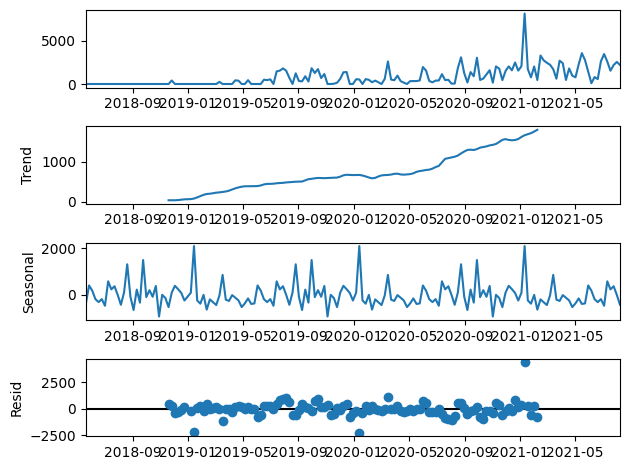

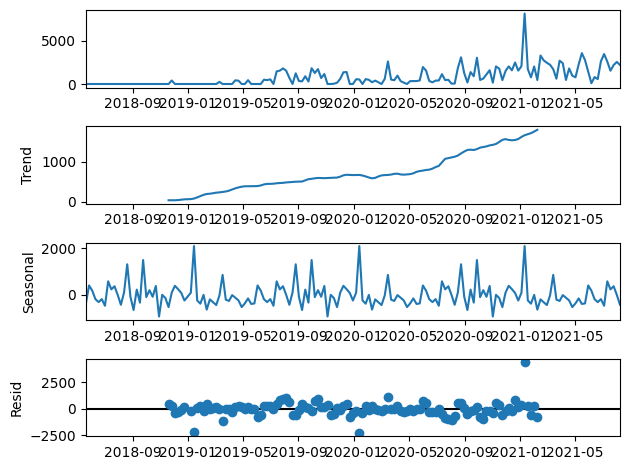

In [32]:
result = seasonal_decompose(curr_df, model='additive',period=52)
result.plot()

In [33]:
df_rolled['Category_PackType_Combination'] = df_rolled['Category'] +  "*" + df_rolled['Pack_Type']
print(df_rolled.shape)
df_rolled = pd.merge(df_rolled,df_ssn_trend,on=['week_date','Category_PackType_Combination'])
print(df_rolled.shape)

df_rolled.isnull().sum()


(125776, 29)
(125776, 31)


week_date                             0
PPG                                   0
Retailer_Name                         0
Week                                  0
Week_Num                              0
Category                              0
Brand                                 0
Sub_Brand                             0
Pack_Type                             0
Pack_Size                             0
Pack_Size_Num                         0
year                                  0
week_number                           0
month                                 0
Promo_Volume                     108191
Non_Promo_Volume                  58177
Promo_Value                      108191
Non_Promo_Value                   58177
Distribution_wtd                  57147
Distribution_numeric              57050
Total_Value                      111067
Total_Volume                     111067
Avg_Price_Per_KG                 111067
Promo_Price_Per_KG               108191
Non_Promo_Price_Per_KG            58177


/var/folders/zm/64325rdn3f10y5cfd9wwdz7h0000gn/T/ipykernel_9460/4168011585.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<AxesSubplot: >

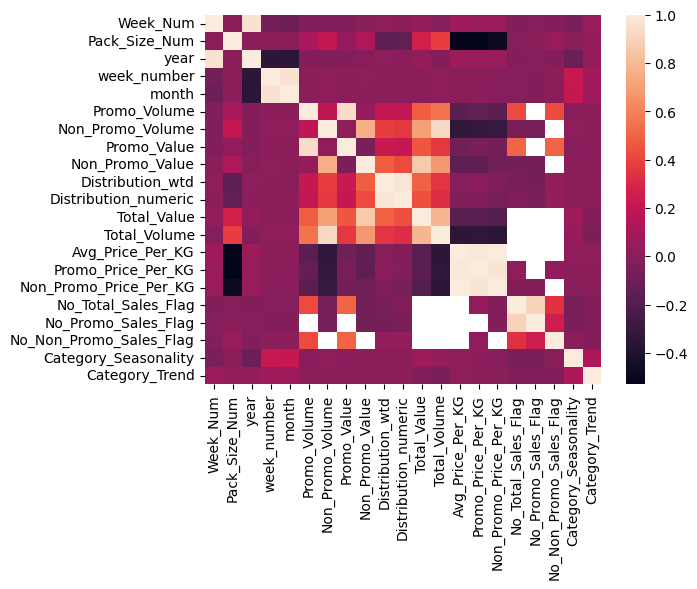

In [34]:
corr = df_rolled.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [35]:
#Write to parquet
df_rolled.to_parquet("../data/output/df_model.parquet")

In [36]:
df_rolled.to_clipboard()

In [38]:
df_rolled.to_csv("data.csv",index=False)